In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
import cv2 
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

In [ ]:
base_model = DenseNet121(weights='imagenet' , include_top = False , pooling='avg')

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
x = base_model.output

In [ ]:
predections = Dense(14 , activation="sigmoid")(x)

In [ ]:
model = Model(inputs=base_model.input , outputs=predections)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/project001/xr14m/pretrained_model.h5')

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/project001/person1946_bacteria_4874.jpeg'
img = tf.keras.utils.load_img(
    path, target_size=(224,224)
)

In [ ]:
import numpy as np

In [ ]:
x = np.array(img)

In [ ]:
mean = np.mean(x)
std = np.std(x)
x = x -mean
x = x / std
x = np.expand_dims(x , axis=0)

In [ ]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [ ]:
preds = model.predict(x)

In [ ]:
np.argmax(preds)

8

In [ ]:
import pandas as pd
pred_df = pd.DataFrame(preds , columns=labels)

In [ ]:
pred_df

,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,0.461458,0.764471,0.315253,0.161388,0.804246,0.580892,0.493769,0.307794,0.820944,0.733628,0.756328,0.586837,0.636592,0.764336


In [ ]:
def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

In [ ]:
def compute_gradcam(model, img, image_dir, df, labels, selected_labels, layer_name='bn',
                   W = 224, H=224):
    
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)
    
    ##############################
    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')
    ##############################
    
    
    layer_name='bn'
    conv_output = model.get_layer(layer_name).output
    gradModel = Model(
                inputs=[model.inputs],
                outputs=[conv_output,model.output])
    
    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")

            cls = 0 # specific class output probability
            with tf.GradientTape() as tape:
                (convOutputs, pred) = gradModel(preprocessed_input)
                loss = pred[:, cls]
            # use automatic differentiation to compute the gradients
            grads = tape.gradient(loss, convOutputs)
            
            output, grads_val = convOutputs[0, :], grads[0, :, :, :] #no need of batch information

            weights = np.mean(grads_val, axis=(0, 1))
            cam = np.dot(output, weights)

            # Process CAM
            cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
            cam = np.maximum(cam, 0)
            gradcam = cam / cam.max()
            
            ###############################
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),cmap='gray')
            
            #value = np.array(min(0.5, predictions[0][i])).reshape(1,1)
            value = min(0.5, predictions[0][i])
            value = np.repeat(value,W*H).reshape(W,H)
            plt.imshow(gradcam, cmap='jet', alpha=value)
            j += 1
            #################################

In [ ]:
IMAGE_DIR = '/content/drive/MyDrive/Colab Notebooks/project001/'
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project001/train-small.csv')

In [ ]:
def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Emphysema
Generating gradcam for class Effusion
Generating gradcam for class Hernia


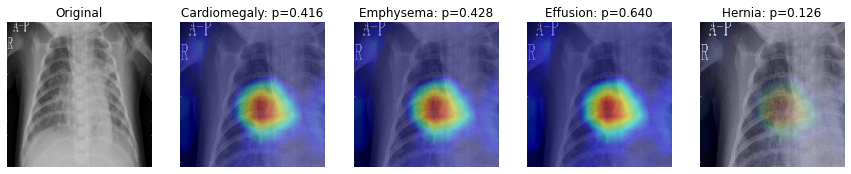

In [ ]:
compute_gradcam(model ,'person1946_bacteria_4874.jpeg', IMAGE_DIR , df , labels , labels[:4])

Loading original image
Generating gradcam for class Infiltration
Generating gradcam for class Mass
Generating gradcam for class Nodule
Generating gradcam for class Atelectasis


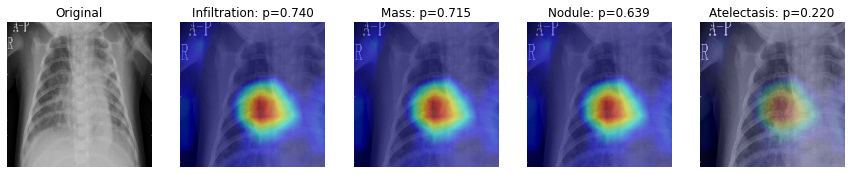

In [ ]:
compute_gradcam(model ,'person1946_bacteria_4874.jpeg', IMAGE_DIR , df , labels , labels[4:8])

Loading original image
Generating gradcam for class Pneumothorax
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Pneumonia
Generating gradcam for class Fibrosis


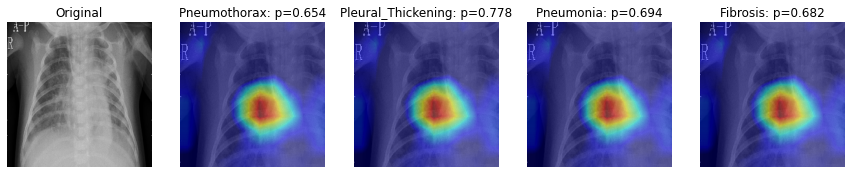

In [ ]:
compute_gradcam(model ,'person1946_bacteria_4874.jpeg', IMAGE_DIR , df , labels , labels[8:12])

Loading original image
Generating gradcam for class Edema
Generating gradcam for class Consolidation


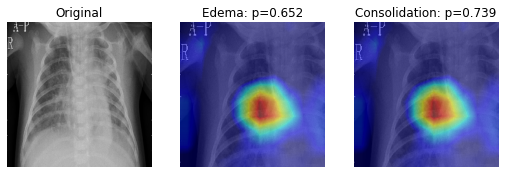

In [ ]:
compute_gradcam(model ,'person1946_bacteria_4874.jpeg', IMAGE_DIR , df , labels , labels[12:])